In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

from dataset import Dataset
from tools import getDataset, print_class_distribution

import numpy as np
from sklearn.model_selection import train_test_split

import random

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [3]:
def make_dataset_loaders(num_classes, batch_size, num_workers, image_size):
    root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
    dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=20, shuffle_images=False)

    class_images = {i: [] for i in range(num_classes)}

    # Group images by class
    for image_path, class_label in dataset:
        class_images[class_label].append((image_path, class_label))

    # Initialize training and test sets
    train_set = []
    test_set = []

    # Select 5 images for training and 15 for testing from each class
    for class_label, images in class_images.items():
        train_set.extend(random.sample(images, k=5))
        test_set.extend(list(set(images) - set(train_set)))


    train_transforms = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.RandomCrop(image_size, padding=8),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=5),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

    test_transforms = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        
    train_dataset = Dataset(dataset=train_set, path=root_dir, phase='train', transform=train_transforms)
    test_dataset = Dataset(dataset=test_set, path=root_dir, phase='test', transform=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    #print_class_distribution(train_dataset, "Training", label_mapping)
    #print_class_distribution(test_dataset, "Testing", label_mapping)

    return train_loader, test_loader

In [4]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing -> batch: %d correct: %d num of images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, train_loader, test_loader, num_epochs, learning_rate):

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(params= net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(0.5, 0.999))
    scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        net.train()
        correct = 0.0  # used to accumulate number of correctly recognized images
        num_images = 0.0  # used to accumulate number of images
        total_loss = 0.0

        for i_batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            output_train = net(images)
            loss = criterion(output_train, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicts = output_train.argmax(dim=1)
            correct += predicts.eq(labels).sum().item()
            num_images += len(labels)
            total_loss += loss.item()

            print('training -> epoch: %d, batch: %d, loss: %f' % (epoch, i_batch, loss.item()) + '\r', end='')

        print()
        acc = correct / num_images
        acc_test, test_loss = eval(net, test_loader)
        average_loss = total_loss / len(train_loader)
        training_losses.append(average_loss)
        val_losses.append(test_loss)
        print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, test accuracy: %f test loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_test, test_loss))

        scheduler.step()

    return net, training_losses, val_losses

In [5]:
from models.ViT import ViT

batch_size = 5
num_workers = 4
learning_rate = 0.0001 # 0.00005 - the best one so far
num_epochs = 5
num_classes = 5
image_size = 224
iterations = 10

print(f"Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Number of Workers: {num_workers}")
print(f"Number of Classes: {num_classes}\n")


loaded_model = torch.load(os.path.join(os.getcwd(), 'pretrained/vit_model_best_89.pth'))
model = ViT(num_classes=50).to(device)

# Load the state dictionary into your model
model.load_state_dict(loaded_model)

in_features = model.vit.head.in_features
model.vit.head = nn.Linear(in_features, num_classes).to(device)  

for param in model.parameters():
    param.requires_grad = True

total_test_loss = 0.0
total_test_acc = 0.0

for iter in range(iterations):
    print('--------------------------------------------------------------')
    print(f"Training Iteration: {iter}")
    train_loader, test_loader = make_dataset_loaders(num_classes=num_classes, batch_size=batch_size, num_workers=num_workers, image_size=image_size)
    model, training_losses, val_losses = train(net=model, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, learning_rate=learning_rate)

    acc_test, test_loss = eval(model, test_loader)
    total_test_loss += test_loss
    total_test_acc += acc_test
    print('\naccuracy on testing data: %f' % acc_test)
    print('loss on testing data: %f' % test_loss)

print("---------------------------------------------")   
print(f"Average Test Accuracy: {total_test_acc/iterations}")
print(f"Average Test Loss: {total_test_loss/iterations}")

Hyperparameters:
Batch Size: 5
Learning Rate: 0.0001
Number of Epochs: 5
Number of Workers: 4
Number of Classes: 5

--------------------------------------------------------------
Training Iteration: 0
Using 20 images per class AnnualCrop
Using 20 images per class Industrial
Using 20 images per class Forest
Using 20 images per class SeaLake
Using 20 images per class Residential
training -> epoch: 0, batch: 4, loss: 0.878478
testing -> batch: 14 correct: 61 num of images: 75
epoch: 0, lr: 0.000100, accuracy: 0.440000, avg. loss: 1.407665, test accuracy: 0.813333 test loss: 0.447006

training -> epoch: 1, batch: 4, loss: 0.031124
testing -> batch: 14 correct: 68 num of images: 75
epoch: 1, lr: 0.000100, accuracy: 1.000000, avg. loss: 0.095097, test accuracy: 0.906667 test loss: 0.306215

training -> epoch: 2, batch: 4, loss: 0.023333
testing -> batch: 14 correct: 69 num of images: 75
epoch: 2, lr: 0.000100, accuracy: 1.000000, avg. loss: 0.020584, test accuracy: 0.920000 test loss: 0.2422

testing -> batch: 14 correct: 57 num of images: 75
epoch: 3, lr: 0.000100, accuracy: 0.920000, avg. loss: 0.206095, test accuracy: 0.760000 test loss: 0.489894

training -> epoch: 4, batch: 4, loss: 0.045234
testing -> batch: 14 correct: 60 num of images: 75
epoch: 4, lr: 0.000100, accuracy: 1.000000, avg. loss: 0.042535, test accuracy: 0.800000 test loss: 0.451404

testing -> batch: 14 correct: 60 num of images: 75
accuracy on testing data: 0.800000
loss on testing data: 0.451404
--------------------------------------------------------------
Training Iteration: 6
Using 20 images per class Forest
Using 20 images per class HerbaceousVegetation
Using 20 images per class Pasture
Using 20 images per class PermanentCrop
Using 20 images per class Residential
training -> epoch: 0, batch: 4, loss: 1.707746
testing -> batch: 14 correct: 46 num of images: 75
epoch: 0, lr: 0.000100, accuracy: 0.280000, avg. loss: 2.579975, test accuracy: 0.613333 test loss: 1.027597

training -> epoch: 1, batch: 

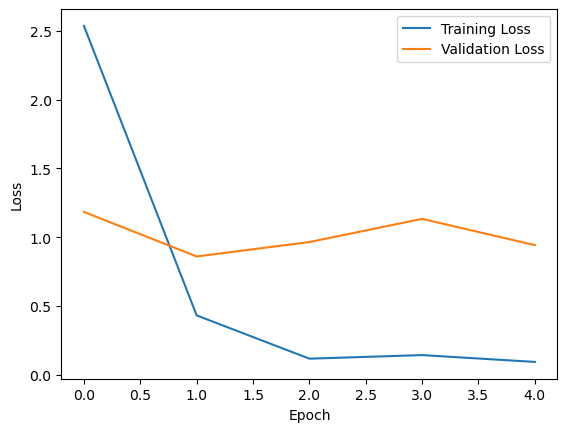

In [11]:
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Using 5 images per class PermanentCrop
Using 5 images per class Pasture
Using 5 images per class AnnualCrop
Using 5 images per class SeaLake
Using 5 images per class Forest


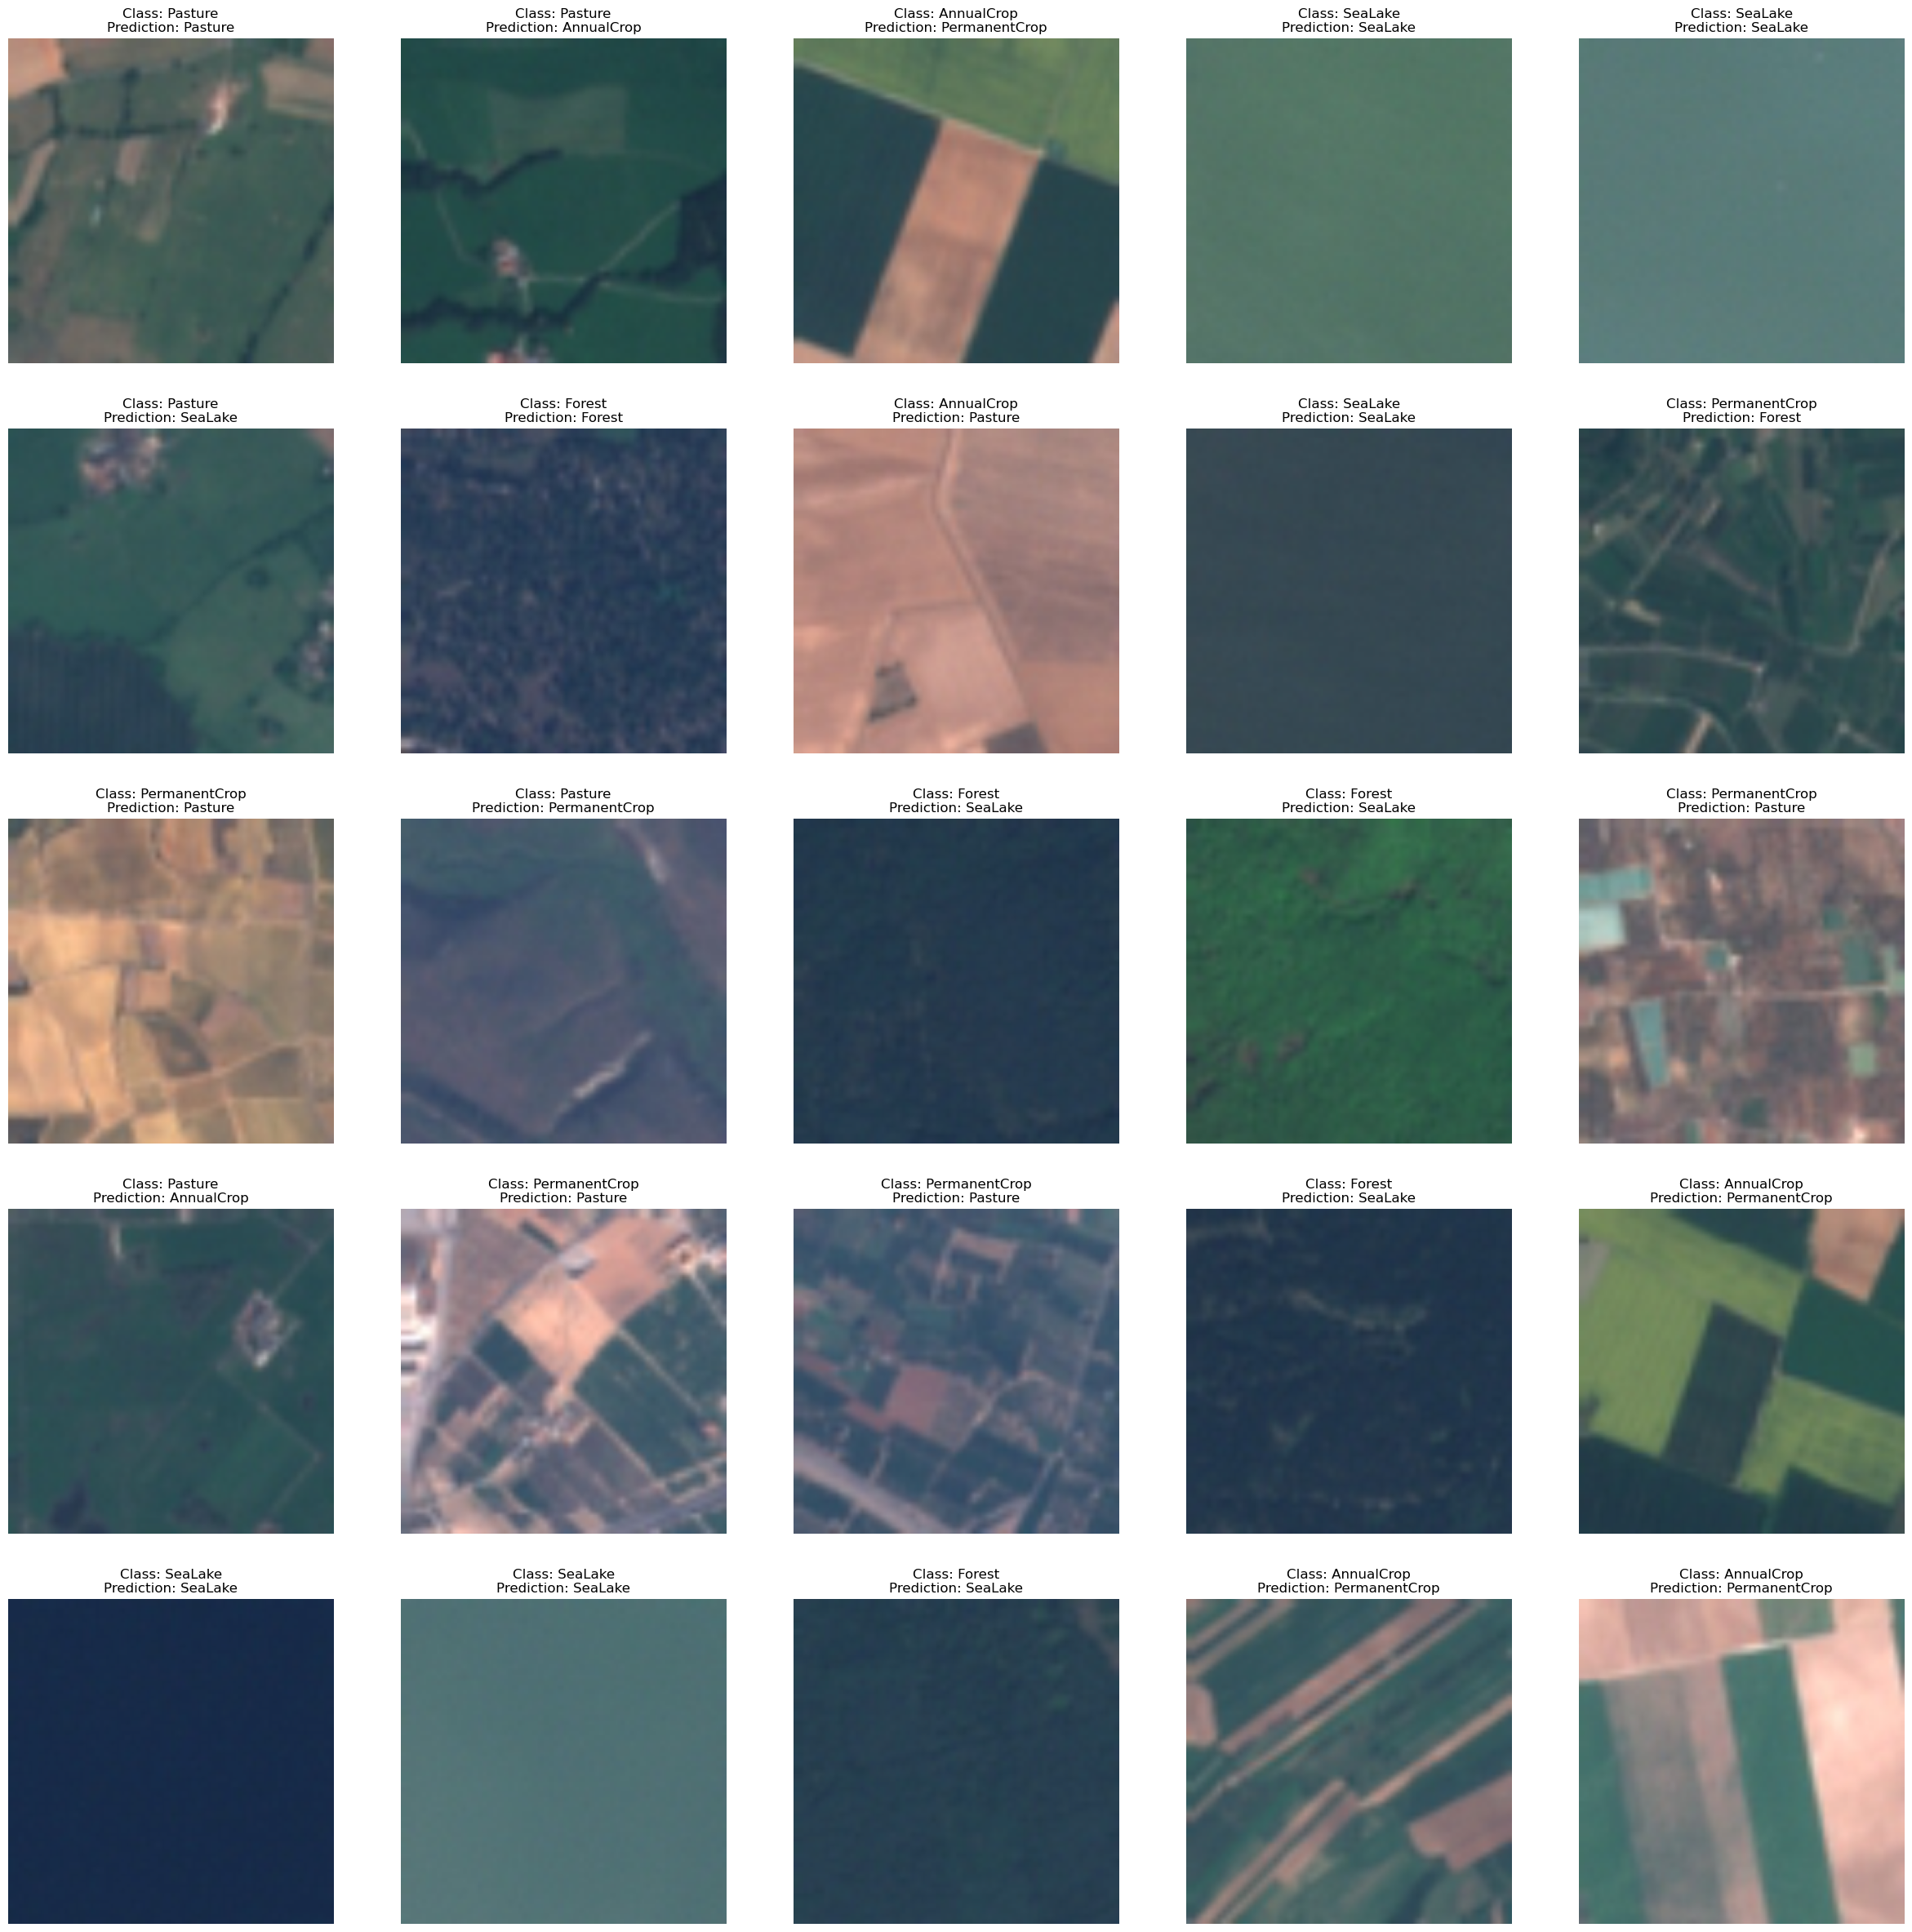

In [16]:
from torchvision import transforms, datasets

root_dir = os.path.join(os.getcwd(), 'datasets/EuroSAT_RGB')
dataset, label_mapping = getDataset(path=root_dir, num_classes=num_classes, num_images_per_class=5, shuffle_images=False)

class_images = {i: [] for i in range(num_classes)}

# Group images by class
for image_path, class_label in dataset:
    class_images[class_label].append((image_path, class_label))

# Initialize training and test sets
test_set = []

# Select 5 images for training and 15 for testing from each class
for class_label, images in class_images.items():
    test_set.extend(random.sample(images, k=5))
        
transforms = transforms.Compose(
            [
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        
dataset = Dataset(dataset=test_set, path=root_dir, transform=transforms)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=num_workers)

model.eval()
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
        
fig, axs = plt.subplots(5, 5, figsize=(30, 30))  # Adjust figsize as needed

for i_batch, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outs = model(images)
        _, predict = torch.max(outs.data, 1)
        ax = axs[int(i_batch/5), i_batch%5]
        ax.set_title('Class: {}\nPrediction: {}'.format(label_mapping[labels[0].item()],
                                                        label_mapping[predict[0].item()]))
        ax.axis('off')

        # Revert normalization
        images_display = images[0].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        images_display = std * images_display + mean
        images_display = np.clip(images_display, 0, 1) 

        ax.imshow(images_display)  # Assuming images are in CHW format


In [8]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), f'trained/vit_trained_{round(total_test_acc/iterations * 100, 2)}.pth'))